# Modflow/Modpath basics

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import geone.imgplot3d as imgplt3
import pyvista as pv
import sys
import os

sys.path.append("../../")
#my modules
from ArchPy.base import *
from ArchPy.tpgs import *

In [2]:
#grid
sx = 1.5
sy = 1.5
sz = .15
x0 = 0
y0 = 0
z0 = -15
nx = 140
ny = 70
nz = 70
x1 = x0 + nx*sx
y1 = y0 + ny*sy
z1 = z0 + nz

dimensions = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (x0, y0, z0)  

In [3]:
## create pile

P1 = Pile(name = "P1",seed=1)

#units covmodel
covmodelD = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodelD1 = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[30,30]})])
covmodelC = gcm.CovModel2D(elem=[('cubic', {'w':0.2, 'r':[40,40]})])
covmodelB = gcm.CovModel2D(elem=[('cubic', {'w':0.6, 'r':[30,30]})])
covmodel_er = gcm.CovModel2D(elem=[('spherical', {'w':1, 'r':[50,50]})])

## facies covmodel
covmodel_SIS_C = gcm.CovModel3D(elem=[("exponential", {"w":.21,"r":[50, 50, 10]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B1 = gcm.CovModel3D(elem=[("exponential", {"w":.16,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B2 = gcm.CovModel3D(elem=[("exponential", {"w":.24,"r":[100, 100, 3]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B3 = gcm.CovModel3D(elem=[("exponential", {"w":.19,"r":[50, 50, 2]})], alpha=0, name="vario_SIS") # input variogram
covmodel_SIS_B4 = gcm.CovModel3D(elem=[("exponential", {"w":.13,"r":[100, 100, 4]})], alpha=0, name="vario_SIS") # input variogram

lst_covmodelC=[covmodel_SIS_C] # list of covmodels to pass at the function
lst_covmodelB=[covmodel_SIS_B1, covmodel_SIS_B2, covmodel_SIS_B3, covmodel_SIS_B4] # list of covmodels to pass


#create Lithologies 
dic_s_D = {"int_method" : "grf_ineq","covmodel" : covmodelD}
dic_f_D = {"f_method":"homogenous"}
D = Unit(name="D",order=1,ID = 1,color="gold",contact="onlap",surface=Surface(contact="onlap",dic_surf=dic_s_D)
         ,dic_facies=dic_f_D)

dic_s_C = {"int_method" : "grf_ineq","covmodel" : covmodelC, "mean":-6.5}
dic_f_C = {"f_method" : "SIS","neig" : 10, "f_covmodel":lst_covmodelC, "probability":[0.3, 0.7]}
C = Unit(name="C", order=2, ID = 2, color="blue", contact="onlap", dic_facies=dic_f_C, surface=Surface(dic_surf=dic_s_C, contact="onlap"))

dic_s_B = {"int_method" : "grf_ineq","covmodel" : covmodelB, "mean":-8.5}
dic_f_B = {"f_method":"SIS", "neig" : 10, "f_covmodel":lst_covmodelB, "probability":[0.2, 0.4, 0.25, 0.15]}
B = Unit(name="B",order=3,ID = 3,color="purple",contact="onlap",dic_facies=dic_f_B,surface=Surface(contact="onlap",dic_surf=dic_s_B))

dic_s_A = {"int_method":"grf_ineq","covmodel": covmodelB, "mean":-11}
dic_f_A = {"f_method":"homogenous"}
A = Unit(name="A",order=5,ID = 5,color="red",contact="onlap",dic_facies=dic_f_A,surface=Surface(dic_surf = dic_s_A,contact="onlap"))

#Master pile
P1.add_unit([D,C,B,A])

Unit D: Surface added for interpolation
Unit C: Surface added for interpolation
Unit B: Surface added for interpolation
Unit A: Surface added for interpolation
Stratigraphic unit D added
Stratigraphic unit C added
Stratigraphic unit B added
Stratigraphic unit A added


In [4]:
# covmodels for the property model
covmodelK = gcm.CovModel3D(elem=[("exponential",{"w":0.3,"r":[30,30,10]})],alpha=-20,name="K_vario")
covmodelK2 = gcm.CovModel3D(elem=[("spherical",{"w":0.1,"r":[20,20, 5]})],alpha=0,name="K_vario_2")

facies_1 = Facies(ID = 1,name="Sand",color="yellow")
facies_2 = Facies(ID = 2,name="Gravel",color="lightgreen")
facies_3 = Facies(ID = 3,name="GM",color="blueviolet")
facies_4 = Facies(ID = 4,name="Clay",color="blue")
facies_5 = Facies(ID = 5,name="SM",color="brown")
facies_6 = Facies(ID = 6,name="Silt",color="goldenrod")
facies_7 = Facies(ID = 7,name="basement",color="red")

A.add_facies([facies_7])
B.add_facies([facies_1, facies_2, facies_3, facies_5])
D.add_facies([facies_1])
C.add_facies([facies_4, facies_6])

# property model
cm_prop1 = gcm.CovModel3D(elem = [("spherical", {"w":0.1, "r":[10,10,10]}),
                                  ("cubic", {"w":0.1, "r":[15,15,15]})])
cm_prop2 = gcm.CovModel3D(elem = [("cubic", {"w":0.2, "r":[25, 25, 5]})])

list_facies = [facies_1, facies_2, facies_3, facies_4, facies_5, facies_6, facies_7]
list_covmodels = [cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2, cm_prop1, cm_prop2]
means = [-4, -2, -6, -9, -6, -7, -19]
prop_model = ArchPy.base.Prop("K",
                              facies = list_facies,
                              covmodels = list_covmodels,
                                means = means,
                                int_method = "sgs",
                                vmin = -10,
                                vmax = -1
                                )



Facies basement added to unit A
Facies Sand added to unit B
Facies Gravel added to unit B
Facies GM added to unit B
Facies SM added to unit B
Facies Sand added to unit D
Facies Clay added to unit C
Facies Silt added to unit C


In [5]:
top = np.ones([ny,nx])*-6
bot = np.ones([ny,nx])*z0

In [6]:
T1 = Arch_table(name = "P1",seed=3)
T1.set_Pile_master(P1)
T1.add_grid(dimensions, spacing, origin, top=top,bot=bot)
T1.add_prop(prop_model)

Pile sets as Pile master
## Adding Grid ##
## Grid added and is now simulation grid ##
Property K added


In [7]:
T1.compute_surf(1)
T1.compute_facies(1)
T1.compute_prop(1)

Boreholes not processed, fully unconditional simulations will be tempted
########## PILE P1 ##########
Pile P1: ordering units
Stratigraphic units have been sorted according to order
Discrepency in the orders for units A and B
Changing orders for that they range from 1 to n

#### COMPUTING SURFACE OF UNIT A
A: time elapsed for computing surface 0.04293322563171387 s

#### COMPUTING SURFACE OF UNIT B
B: time elapsed for computing surface 0.02544116973876953 s

#### COMPUTING SURFACE OF UNIT C
C: time elapsed for computing surface 0.02501368522644043 s

#### COMPUTING SURFACE OF UNIT D
D: time elapsed for computing surface 0.0 s

Time elapsed for getting domains 0.0953519344329834 s
##########################


### 0.2009413242340088: Total time elapsed for computing surfaces ###

### Unit D: facies simulation with homogenous method ####
### Unit D - realization 0 ###
Time elapsed 0.0 s

### Unit C: facies simulation with SIS method ####
### Unit C - realization 0 ###
Only one facies cov

In [8]:
import flopy as fp

In [9]:
pv.set_jupyter_backend("client")

In [ ]:
T1.plot_units(v_ex=3)

Widget(value='<iframe src="http://localhost:55958/index.html?ui=P_0x236dde36f90_0&reconnect=auto" class="pyvis…

In [11]:
T1.plot_facies(v_ex=3)

Widget(value='<iframe src="http://localhost:55958/index.html?ui=P_0x236e131ee10_1&reconnect=auto" class="pyvis…

In [12]:
T1.plot_prop("K", v_ex=3)

Widget(value='<iframe src="http://localhost:55958/index.html?ui=P_0x236dff50ad0_2&reconnect=auto" class="pyvis…

In [13]:
val = T1.get_prop("K")[0, 0, 0]
im = geone.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=x0, oy=y0, oz=z0, nv=1, val=val)

In [14]:

factor_x = 4
factor_y = 2
factor_z = 2

nlay, nrow, ncol = T1.get_nz(), T1.get_ny(), T1.get_nx()
delr, delc = T1.get_sx(), T1.get_sy()
xoff, yoff = T1.get_ox(), T1.get_oy()

assert factor_x is not None, "factor_x must be provided"
assert factor_y is not None, "factor_y must be provided"
assert factor_z is not None, "factor_z must be provided"
assert nrow % factor_y == 0, "nrow must be divisible by factor_y"
assert ncol % factor_x == 0, "ncol must be divisible by factor_x"
assert nlay % factor_z == 0, "nlay must be divisible by factor_z"
nrow = int(nrow / factor_y)
ncol = int(ncol / factor_x)
nlay = int(nlay / factor_z)
delr = delr * factor_x
delc = delc * factor_y
top = np.ones((nrow, ncol)) * T1.get_zg()[-1]
botm = np.ones((nlay, nrow, ncol)) * T1.get_zg()[::-factor_z][1:].reshape(-1, 1, 1)
botm = np.flip(np.flipud(botm), axis=1)  # flip the array to have the same orientation as the ArchPy table
botm.shape

(35, 35, 35)

In [15]:
delc, delr

(3.0, 6.0)

## archpy2modflow

Here is a simple example of how to use the `archpy2modflow` package to convert an ArchPy model to a MODFLOW model using the `flopy` package.
Several modes can be used to convert the ArchPy model (and grid) to a MODFLOW model (grid). The modes are:
- `archpy` mode: This mode uses the ArchPy grid to create a MODFLOW DIS grid. 
- `layers` mode: This mode considers that each stratigraphic unit is a modflow layer and uses the surfaces simulated by ArchPy to define the bottom elevation of each layer. K values are averaged between the top and bottom of each layer.
- `new_resolution` mode: upscaled model using the uppy package. New resolution is defined as a factor of reduction in each direction. For example, if the factor in x direction is 2, the new model will have half the number of cells in the x direction, while the number of cells in the y and z directions will remain the same.

Now imagine that you want to set one or several units as inactive in the MODFLOW model (e.g., bedrock, impervious bottom), you can set this with the ``unit_limit`` parameter of the ``create_sim`` method. This parameter takes a unit name as input and will consider itself and all units below it as inactive. 

```python
### archpy mode

In [16]:
import ArchPy.ap_mf
from ArchPy.ap_mf import archpy2modflow, array2cellids

Let us create our modflow model. 

## Modflow model

### ArchPy mode

In [17]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")  # create the modflow model
archpy_flow.create_sim(grid_mode="archpy", iu=0, unit_limit="A")  # create the simulation object and choose a certain discretization
archpy_flow.set_k("K", iu=0, ifa=0, ip=0, log=True)  # set the hydraulic conductivity

Simulation created
To retrieve the simulation, use the get_sim() method


Here we have instantiate a modflow model based on the ArchPy model and using the same grid resolution. The model is created using the `archpy` mode.
We have also set the npf package to use the K values from the ArchPy model. As ArchPy is a stochastic model we have multiple realization, here it is the one that corresponds to iu=0, ifa=0 and ip=0.
We also indicate that K values are in log10 scale.

Now we can retrieve flopy/modflow model and add different packages as we would do with a regular modflow model.

In [18]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

For example some boundary conditions

In [19]:
# add BC at left and right on all layers
h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

 Write modflow model files

In [20]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 4666 based on size of stress_period_data


Here we also modify the solver to an higher complexity as the model contains a large number of cells and have difficult to converge.

In [21]:
sim.ims.complexity = "moderate"
sim.ims.write()

In [22]:
sim.run_simulation()

FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Governm

(False, [])

Now we can retrieve some results. Archpy2modflow objects integrate some basic functions to facilitate this such as ``get_heads`` methods.

In [23]:
heads = archpy_flow.get_heads(kstpkper=(0, 0))
heads[heads == 1e30] = np.nan

In [24]:
cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

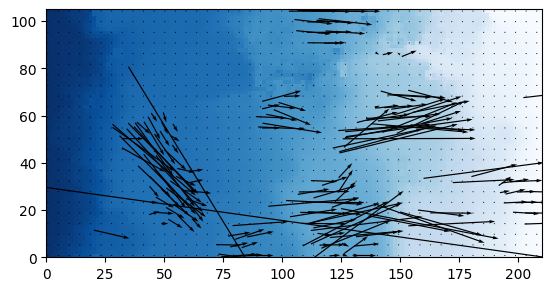

In [25]:
import flopy
from flopy.plot import PlotMapView
mapview = PlotMapView(model=gwf, layer=15)
quadmesh = mapview.plot_array(heads, cmap="Blues")
# quadmesh = mapview.contour_array(heads, cmap="jet", levels=10)
# quadmesh = mapview.plot_array(np.log10(gwf.npf.k.array), cmap="viridis")
mapview.plot_vector(qx, qy, color="black", istep=3, jstep=3)

Be aware that grids between modflow and archpy are not the same. The origin of the grid is at the lowest layer, left and bottom of the model in archpy and at the uppest layer, left and top of the model in modflow (see the figure)

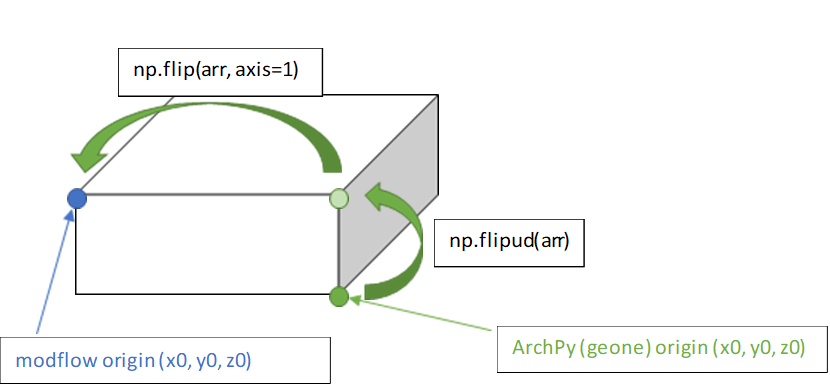
    

If you have a modflow output and want to plot it in 3D using archpy, you need to flip this array using the following command:

```python
heads = np.flipud(np.flip(heads, axis=1))
```

If we make a plot of the resulting model, we see that unit A, the bedrock, has been set as inactive in the model.

In [26]:
heads = archpy_flow.get_heads()
heads[heads == 1e30] = np.nan

T1.plot_arr(np.flipud(np.flip(heads, axis=1)), "head", 2)

Widget(value='<iframe src="http://localhost:55958/index.html?ui=P_0x236e13c60d0_3&reconnect=auto" class="pyvis…

In [27]:
T1.plot_prop("K", v_ex=2)

Widget(value='<iframe src="http://localhost:55958/index.html?ui=P_0x236e1450650_4&reconnect=auto" class="pyvis…

#### Particle tracking

##### Modpath simulations

archpy2modflow also integrates function to run modpath simulations. Here is an example of how to run a modpath simulation. Note that it only works with modpath 7.

First we need to create a modpath model and provide the path to the modpath executable. This is done using ``mp_create`` method as shown below

Initial starting point of particles can be either defined by a list of coordinates or by a list of cell indices. Here we use the first option and we provide a list to ``list_p_coord``. The tracking direction is also defined by the user. Here we use the backward tracking direction.

In [28]:
mpexe_path = "../../../../exe/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)])

c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


In [29]:
archpy_flow.mp_run(silent=False)

FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         3 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


Pathlines and endpoints objects can be retrieve using archpy2modflow functions

In [30]:
p = archpy_flow.mp_get_pathlines_object()
e = archpy_flow.mp_get_endpoints_object()

<Figure size 1000x1000 with 0 Axes>

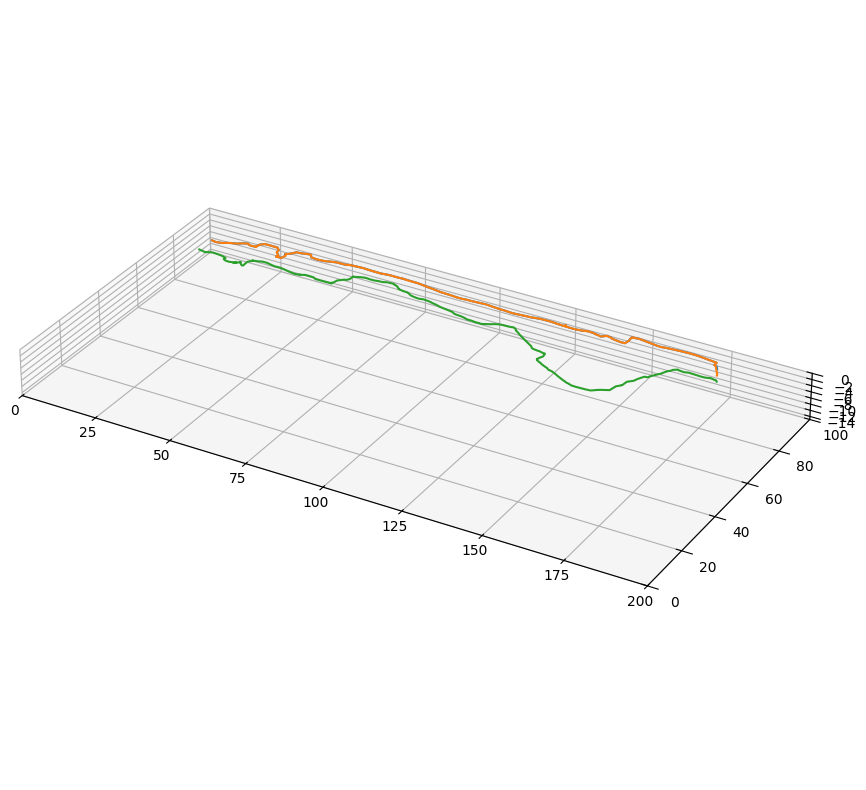

In [31]:
fig = plt.figure(figsize=(10, 10))
path = p.get_alldata()

# 3D plot of the pathlines
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in path:
    ax.plot(pth["x"], pth["y"], pth["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
ax.set_aspect("equal")
plt.show()

If we want to investigate the encountered lithologies along the pathlines we can use the following command:

```python
archpy_flow.mp_get_facies_path_particle(i_particle)
```
where ``i_particle`` is the index of the particle we want to investigate.

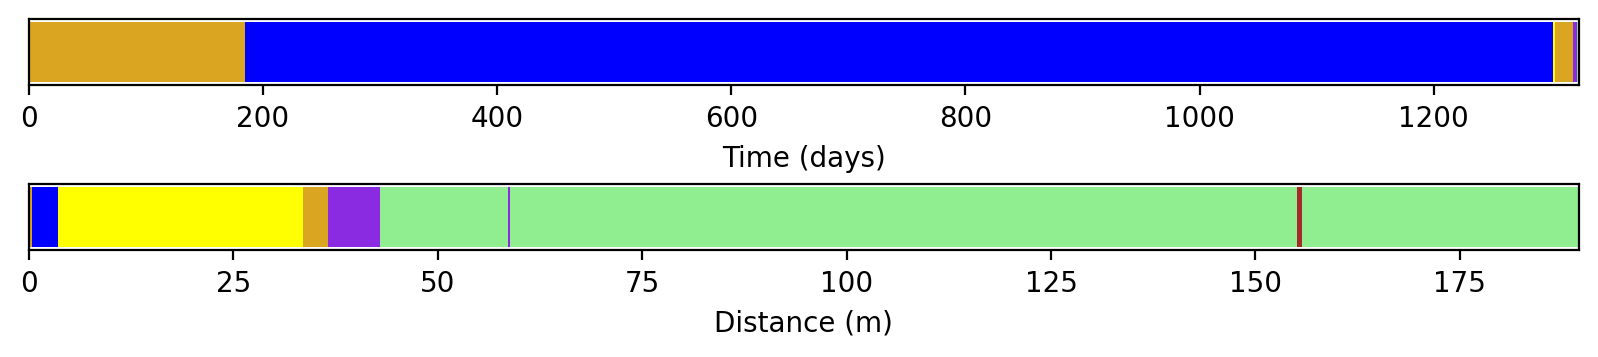

In [32]:
from ArchPy.ap_mf import plot_particle_facies_sequence

df = archpy_flow.mp_get_facies_path_particle(1)  # get the facies sequence of the particles
plot_particle_facies_sequence(T1, df, plot_time=True, plot_distance=True)  # plot facies sequences in time and distance

##### PRT

It can be noted that particle tracking with archpy2modflow can also be done using PRT model from Modflow 6 using similar functions

In [33]:
archpy_flow.prt_create(prt_name="test_prt", workspace="ws_prt", trackdir="backward", list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)])
archpy_flow.prt_run(silent=False)

c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model test_prt...
    writing model name file...
    writing package dis...
    writing package mip...
    writing package prp...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to furthe

<Figure size 1000x1000 with 0 Axes>

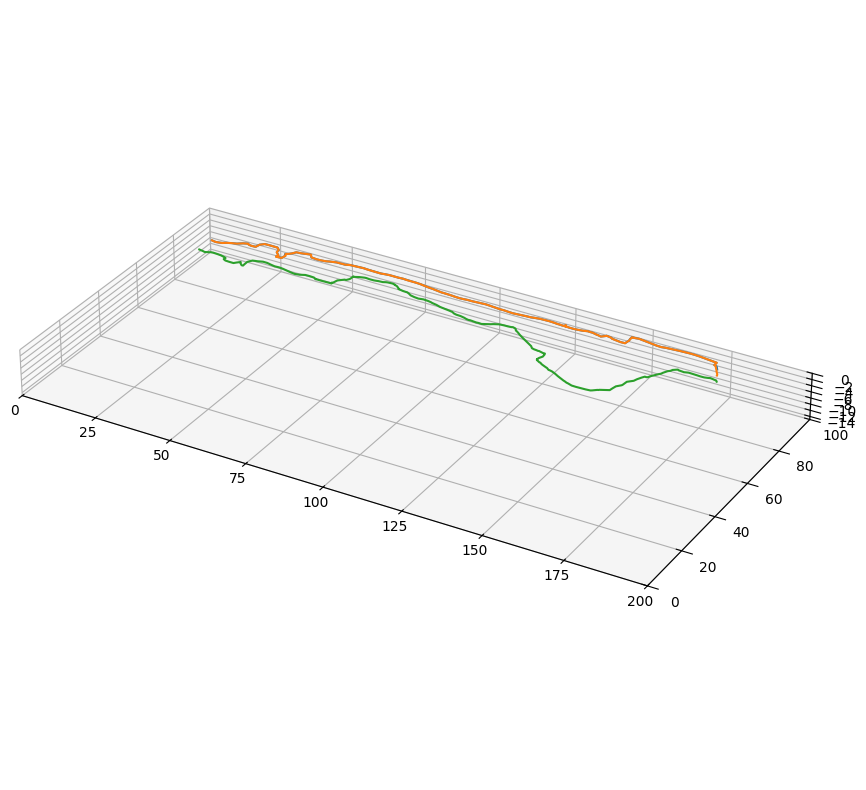

In [34]:
fig = plt.figure(figsize=(10, 10))

# 3D plot of the pathlines
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for i in range(3):
    path = archpy_flow.prt_get_pathlines(i_particle=i+1)
    plt.plot(path["x"], path["y"], path["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
ax.set_aspect("equal")
plt.show()

### Layers mode

Now investigate the layer mode where each archpy unit is now a modflow layer. K values are then averaged to give the mean K values in each cell of the layer. Several averages are available. ``anisotropic`` average performs an arithmetic mean to obtain Kxx and Kyy while Kzz is the harmonic mean of the K values in the layer.

In [35]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")
archpy_flow.create_sim(grid_mode="layers", iu=0, unit_limit="A")
archpy_flow.set_k(k_key="K", iu=0, ifa=0, ip=0, log=True, k_average_method="anisotropic")

Simulation created
To retrieve the simulation, use the get_sim() method


In [36]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [37]:
# add BC at left and right on all layers
h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [38]:
sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 396 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subje

(True, [])

In [39]:
heads = archpy_flow.get_heads()
heads[heads == 1e30] = np.nan

cobj = gwf.output.budget()
qx, qy, qz = fp.utils.postprocessing.get_specific_discharge(
        cobj.get_data(text="DATA-SPDIS", kstpkper=(0, 0))[0], gwf)

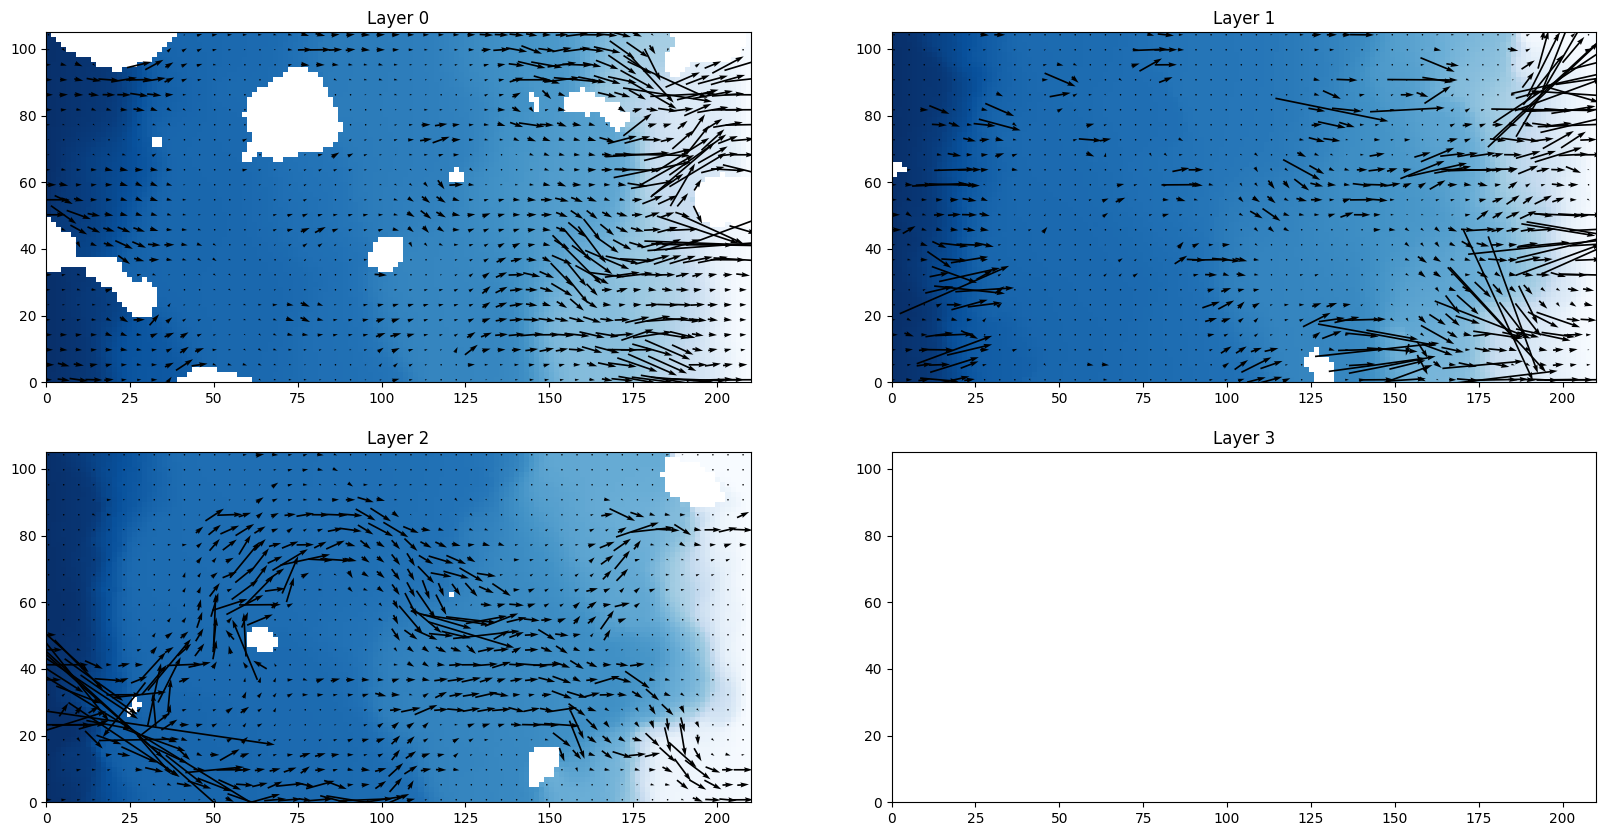

In [40]:
# plots
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
axes = ax.flatten()
from flopy.plot import PlotMapView
for ilayer in range(gwf.modelgrid.nlay):
    mapview = PlotMapView(model=gwf, layer=ilayer, ax=axes[ilayer])
    quadmesh = mapview.plot_array(heads[ilayer], cmap="Blues")
    mapview.plot_vector(qx[ilayer], qy[ilayer], color="black", istep=3, jstep=3)
    axes[ilayer].set_title("Layer {}".format(ilayer))

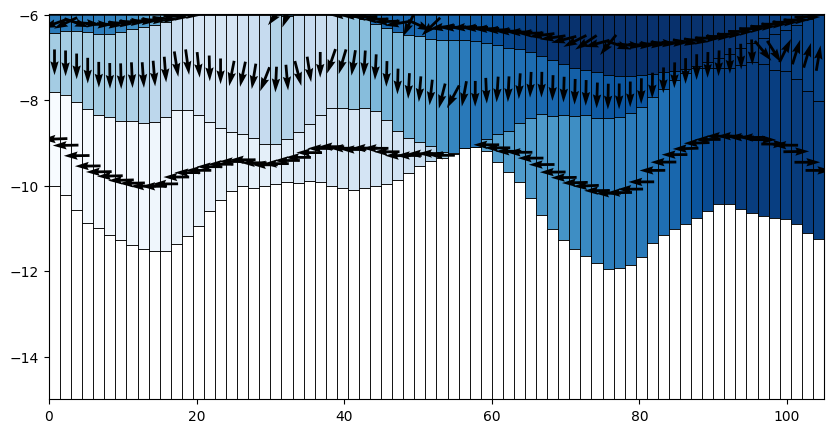

In [41]:
# plot cross section
from flopy.plot import PlotCrossSection
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cross_section = PlotCrossSection(model=gwf, line={"column": 40})
cross_section.plot_array(heads, cmap="Blues", ax=ax)
cross_section.plot_vector(qx, qy, qz, color="black", normalize=True)
cross_section.plot_grid(linewidth=0.5, color="black")

In [42]:
# modpath and pathlines
mpexe_path = "../../../../exe/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)])

c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


In [43]:
archpy_flow.mp_run(silent=False)

FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         3 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


In [44]:
p = archpy_flow.mp_get_pathlines_object()

In [45]:
path = p.get_alldata()

In [46]:
df_pi = archpy_flow.mp_get_facies_path_particle(0, fac_time=1/86400)

As cells were averages into layers, facies too and facies sequences encountered by particles are proportions of facies

(-0.1, 1.1)

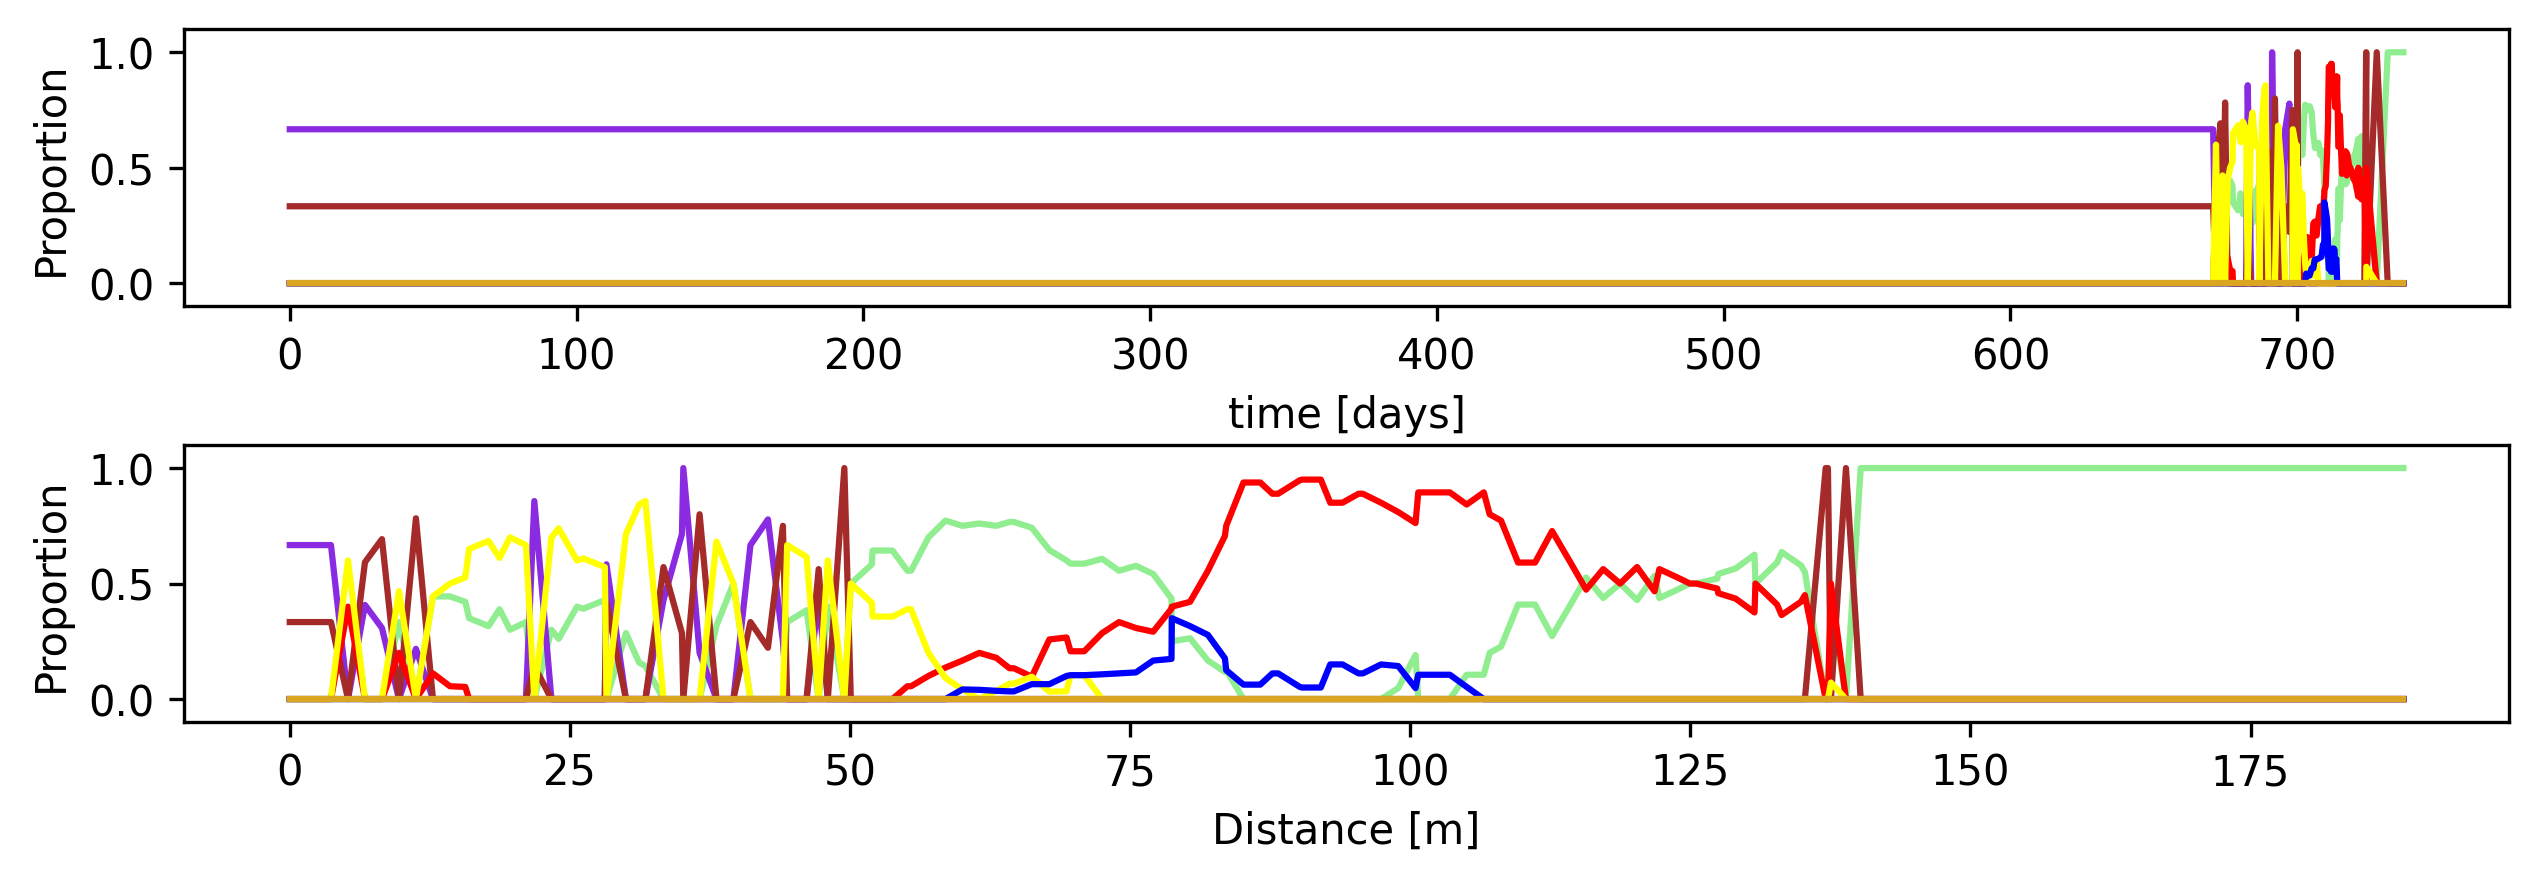

In [47]:
colors_fa = []
for col in df_pi.columns:
    if col.split("_")[0] == "facies":
        id_fa = int(col.split("_")[-1])
        color_fa = archpy_flow.T1.get_facies_obj(ID=id_fa, type="ID").c
        colors_fa.append(color_fa)

fig, ax = plt.subplots(2, 1, figsize=(10, 3), dpi=300)
plt.subplots_adjust(hspace=0.5)
df_pi.set_index("time").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[0])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("time [days]")
ax[0].set_ylim(-.1, 1.1)

df_pi.set_index("cum_distance").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[1])
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Distance [m]")
ax[1].set_ylim(-.1, 1.1)

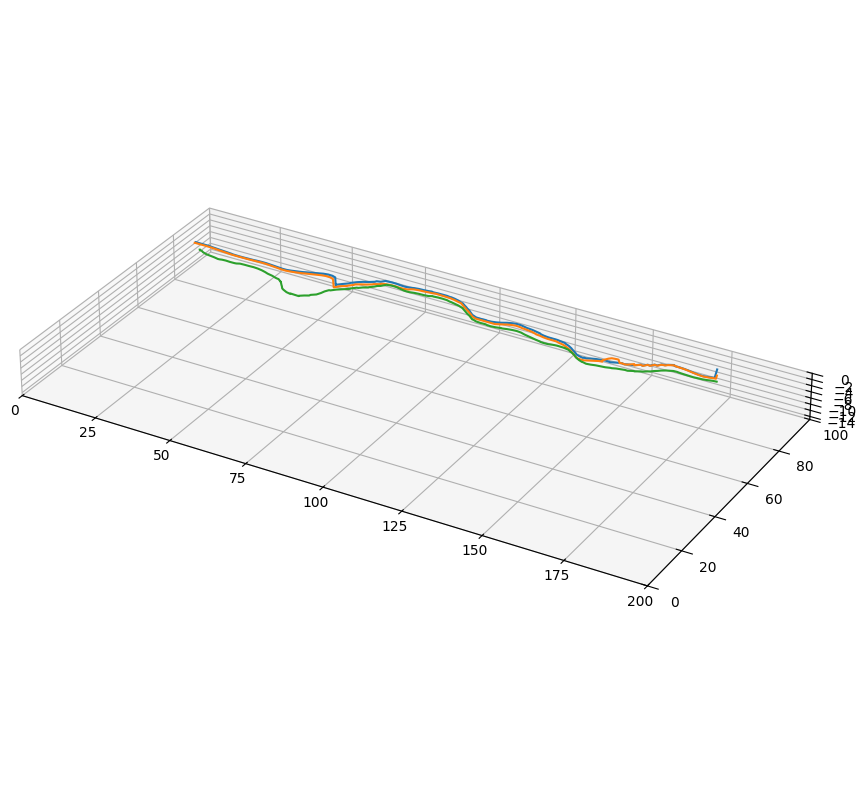

In [48]:
# 3D plot of the pathlines
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in path[:]:
    ax.plot(pth["x"], pth["y"], pth["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
ax.set_aspect("equal")
plt.show()

### Upscaled model

Let us see now the upscaled model. Here we use the new_resolution mode. We upscale the model by a factor of 4 in x direction and 2 in y and z directions.

In [49]:
archpy_flow = archpy2modflow(T1, exe_name="../../../../exe/mf6.exe")
archpy_flow.create_sim(grid_mode="new_resolution", iu=0, factor_x=4, factor_y=2, factor_z=2)
archpy_flow.set_k(k_key="K", iu=0, ifa=0, ip=0, log=True,
                k_average_method="new_resolution")

Simulation created
To retrieve the simulation, use the get_sim() method


In [50]:
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()

In [51]:
pv.set_jupyter_backend("static")

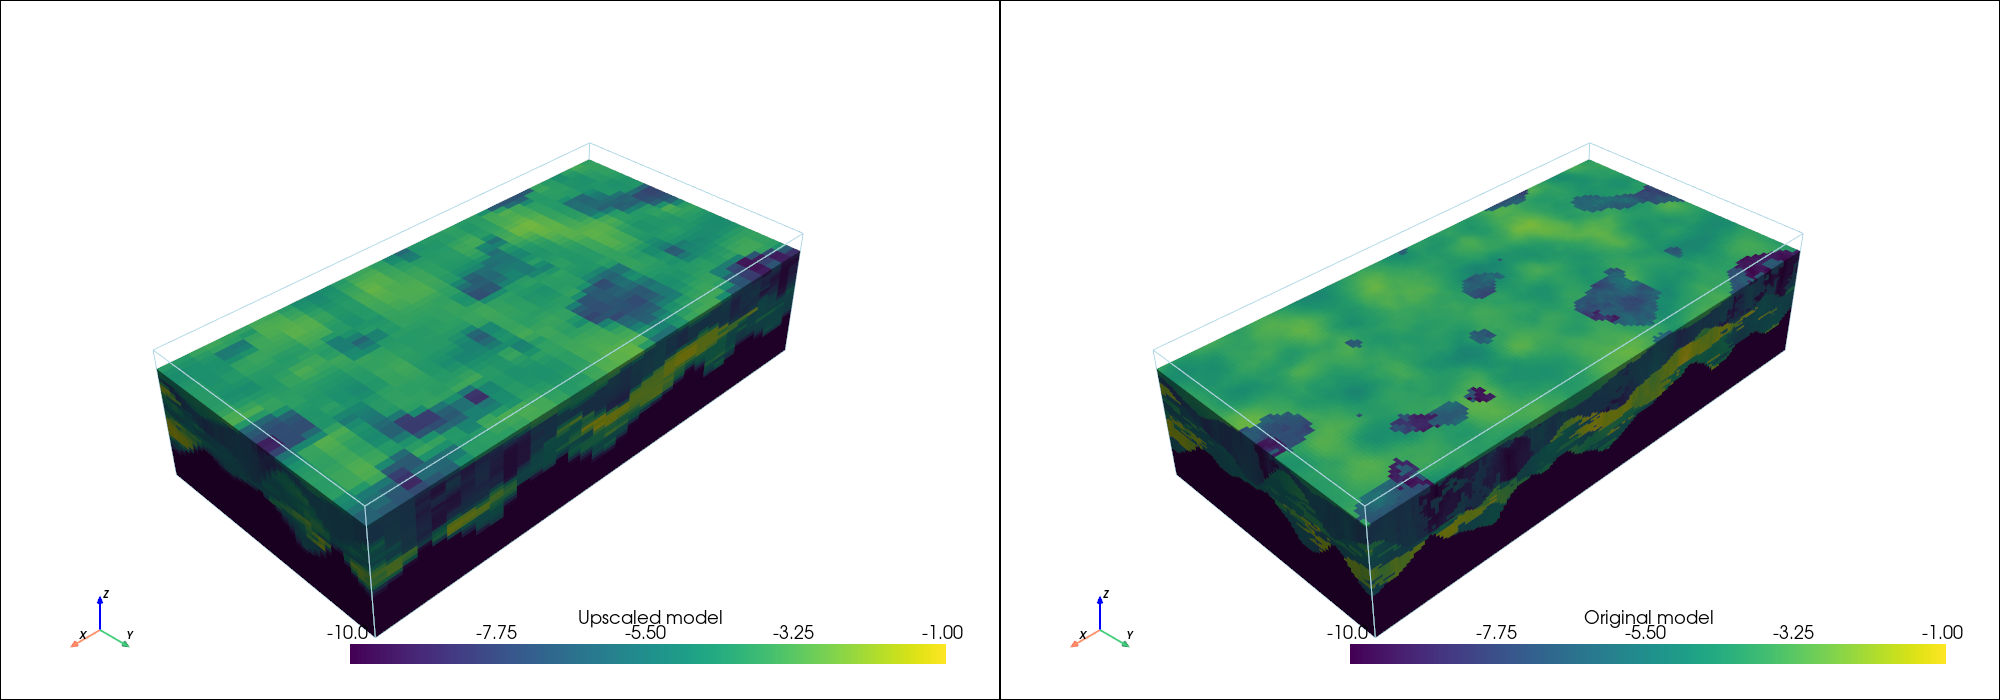

In [52]:
pl = pv.Plotter(shape=(1, 2), window_size=[2000, 700])
v_ex=10
sim = archpy_flow.get_sim()
gwf = archpy_flow.get_gwf()
arr = np.log10(gwf.npf.k.array)
arr[arr==arr[0, 0, 0]] = np.nan
arr = np.flip(np.flipud(arr), axis=1)
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=gwf.dis.delr[0], sy=gwf.dis.delc[0], sz=0.15*v_ex, val=arr, nv=1,
                   varname=["Upscaled model"])
geone.imgplot3d.drawImage3D_surface(im, plotter=pl)


pl.subplot(0, 1)
arr = T1.get_prop("K", 0, 0, 0, all_data=False)
im = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=3, sy=3, sz=0.15*v_ex, nv=1,
                    val=arr.reshape(1, *arr.shape), varname=["Original model"])
geone.imgplot3d.drawImage3D_surface(im, plotter=pl)

pl.show()

In [53]:
# add BC at left and right on all layers
h1 = 100
h2 = 0
chd_data = []

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, 0] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h1))

a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
a[:, :, -1] = 1
lst_chd = array2cellids(a, gwf.dis.idomain.array)
for cellid in lst_chd:
    chd_data.append((cellid, h2))

chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [54]:
sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2100 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subj

(True, [])

In [55]:
mpexe_path = "../../../../exe/mp7.exe"
archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coords=[(170.7, 99.75, -7), (170.7, 99.75, -9), (170.7, 99.75, -11)])
archpy_flow.mp_run(silent=False)

c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         3 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


In [56]:
df_pi = archpy_flow.mp_get_facies_path_particle(0, fac_time=1/86400)

In [57]:
colors_fa = []
for col in df_pi.columns:
    if col.split("_")[0] == "facies":
        id_fa = int(col.split("_")[-1])
        color_fa = archpy_flow.T1.get_facies_obj(ID=id_fa, type="ID").c
        colors_fa.append(color_fa)

(-0.1, 1.1)

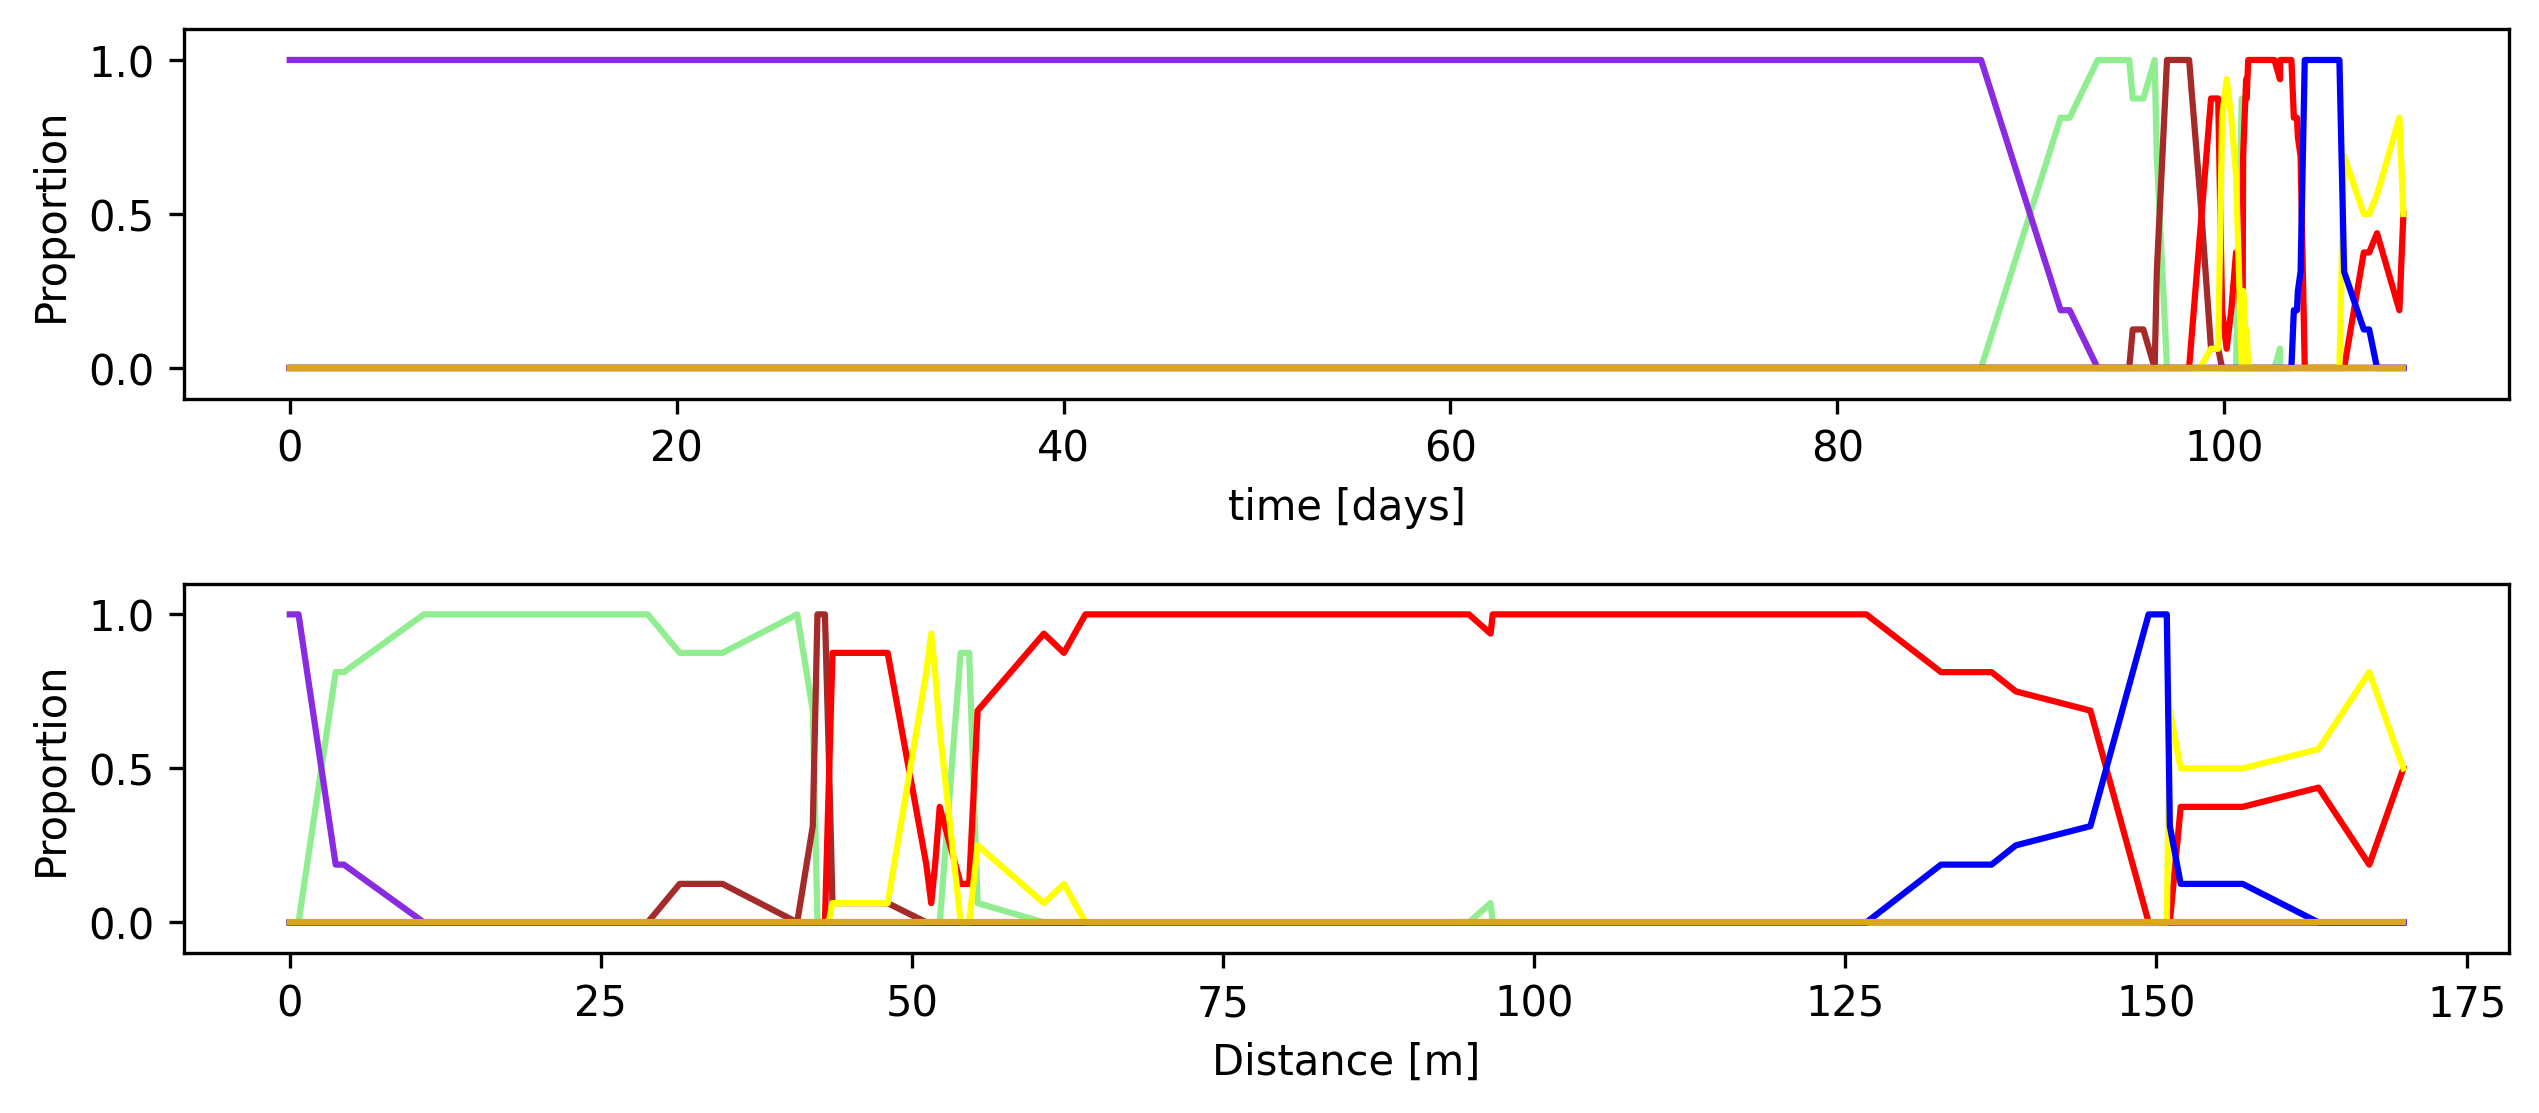

In [58]:
fig, ax = plt.subplots(2, 1, figsize=(10, 4), dpi=300)
plt.subplots_adjust(hspace=0.5)
df_pi.set_index("time").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[0])
ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("time [days]")
ax[0].set_ylim(-.1, 1.1)

df_pi.set_index("cum_distance").iloc[:, 3:].plot(color=colors_fa, legend=False, ax=ax[1])
ax[1].set_ylabel("Proportion")
ax[1].set_xlabel("Distance [m]") 
ax[1].set_ylim(-.1, 1.1)

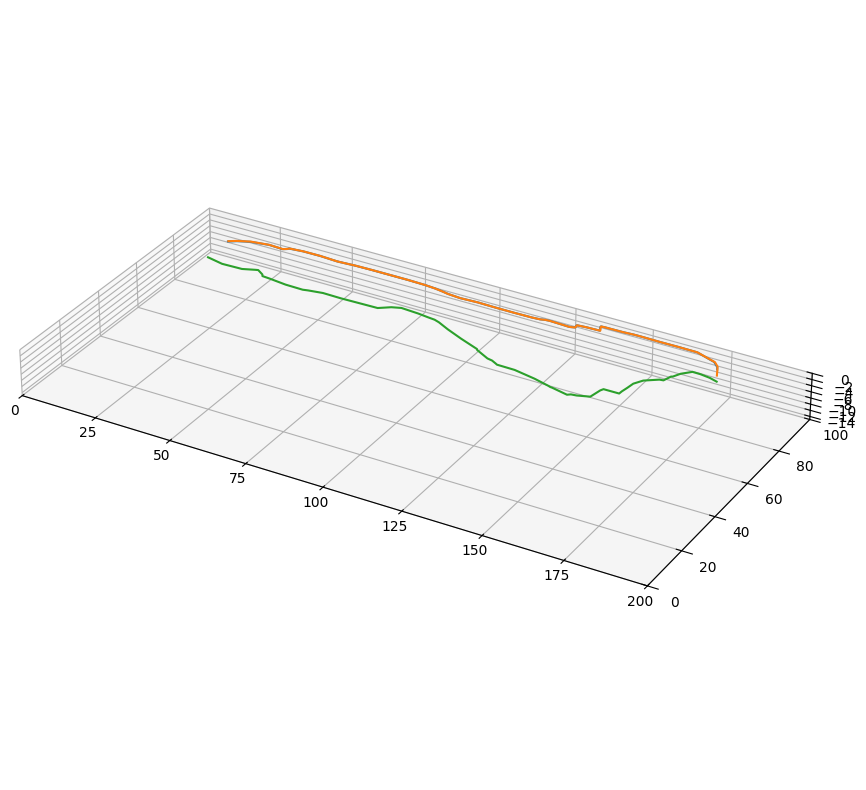

In [59]:
p = archpy_flow.mp_get_pathlines_object()
path = p.get_alldata()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for pth in path[:]:
    ax.plot(pth["x"], pth["y"], pth["z"])

plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, 0)
ax.set_aspect("equal")
plt.show()

## Comparisons

In [60]:
np.random.seed(1)
# compare pathlines between the 3 modes

n_loc = 10
particles_loc_x = np.random.uniform(100, T1.get_xg()[-1], n_loc)
particles_loc_y = np.random.uniform(0, T1.get_yg()[-1], n_loc)
particles_loc_z = np.random.uniform(-12, -7, n_loc)
particles_loc = list(zip(particles_loc_x, particles_loc_y, particles_loc_z))
particles_loc.append((170.7, 99.75, -9))
n_loc += 1

In [61]:
def add_chd(archpy_flow, h1=100, h2=0):

    # add BC at left and right on all layers
    chd_data = []

    gwf = archpy_flow.get_gwf()
    
    a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
    a[:, :, 0] = 1
    lst_chd = array2cellids(a, gwf.dis.idomain.array)
    for cellid in lst_chd:
        chd_data.append((cellid, h1))

    a = np.zeros((gwf.modelgrid.nlay, gwf.modelgrid.nrow, gwf.modelgrid.ncol), dtype=bool)
    a[:, :, -1] = 1
    lst_chd = array2cellids(a, gwf.dis.idomain.array)
    for cellid in lst_chd:
        chd_data.append((cellid, h2))

    chd = fp.mf6.ModflowGwfchd(gwf, stress_period_data=chd_data, save_flows=True)

In [62]:
iu = 0
ifa = 0

mpexe_path = "../../../../exe/mp7.exe"
modflow_path = "../../../../exe/mf6.exe"

# Archpy grid mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="archpy", iu=iu)
archpy_flow.set_k("K", iu, ifa, 0, log=True)

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "complex"
sim.ims.write()
sim.run_simulation()

archpy_flow.mp_create(mpexe=mpexe_path, 
                      trackdir="backward", 
                      list_p_coords=particles_loc)
archpy_flow.mp_run(silent=False)

l_df_pi = []
for pi in range(n_loc):
    df_pi = archpy_flow.mp_get_facies_path_particle(pi, fac_time=1/86400)
    l_df_pi.append(df_pi)

# Layers grid mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="layers", iu=iu)
archpy_flow.set_k("K", iu, ifa, 0, log=True)

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

archpy_flow.mp_create(mpexe=mpexe_path,
                        trackdir="backward",
                        list_p_coords=particles_loc)
archpy_flow.mp_run(silent=False)

l_df_pi_layers = []
for pi in range(n_loc):
    df_pi = archpy_flow.mp_get_facies_path_particle(pi, fac_time=1/86400)
    l_df_pi_layers.append(df_pi)

# New resolution grid mode #
archpy_flow = archpy2modflow(T1, exe_name=modflow_path)
archpy_flow.create_sim(grid_mode="new_resolution", iu=iu, factor_x=4, factor_y=2, factor_z=2)
archpy_flow.set_k("K", iu, ifa, 0, log=True, k_average_method="new_resolution")

sim = archpy_flow.get_sim()

add_chd(archpy_flow, 100, 0)

sim.write_simulation()
sim.ims.complexity = "moderate"
sim.ims.write()
sim.run_simulation()

archpy_flow.mp_create(mpexe=mpexe_path,
                        trackdir="backward",
                        list_p_coords=particles_loc)
archpy_flow.mp_run(silent=False)

l_df_pi_new_res = []
for pi in range(n_loc):
    df_pi = archpy_flow.mp_get_facies_path_particle(pi, fac_time=1/86400)
    l_df_pi_new_res.append(df_pi)


Simulation created
To retrieve the simulation, use the get_sim() method
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 8400 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled Jun 21 2024 02:57:23 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by

c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        11 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        
Simulation created
To re

c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        11 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        
Simulation created
To retrieve the simulation, use the get_sim() method
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model te

c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\flopy\utils\gridintersect.py:123: DeprecationWarning: Note `method="structured"` is deprecated. Pass `method="vertex"` to silence this warning. This will be the new default in a future release and this keyword argument will be removed.
  warnings.warn(


FloPy is using the following executable to run the model: ..\..\..\..\..\exe\mp7.exe

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 03:01:44 with IFORT compiler (ver. 20.21.7)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        11 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


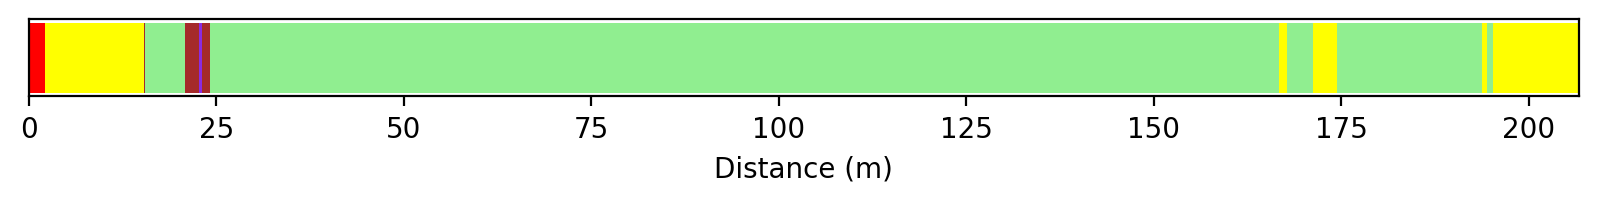

In [63]:
ArchPy.ap_mf.plot_particle_facies_sequence(archpy_flow.T1, l_df_pi[8], plot_distance=True)

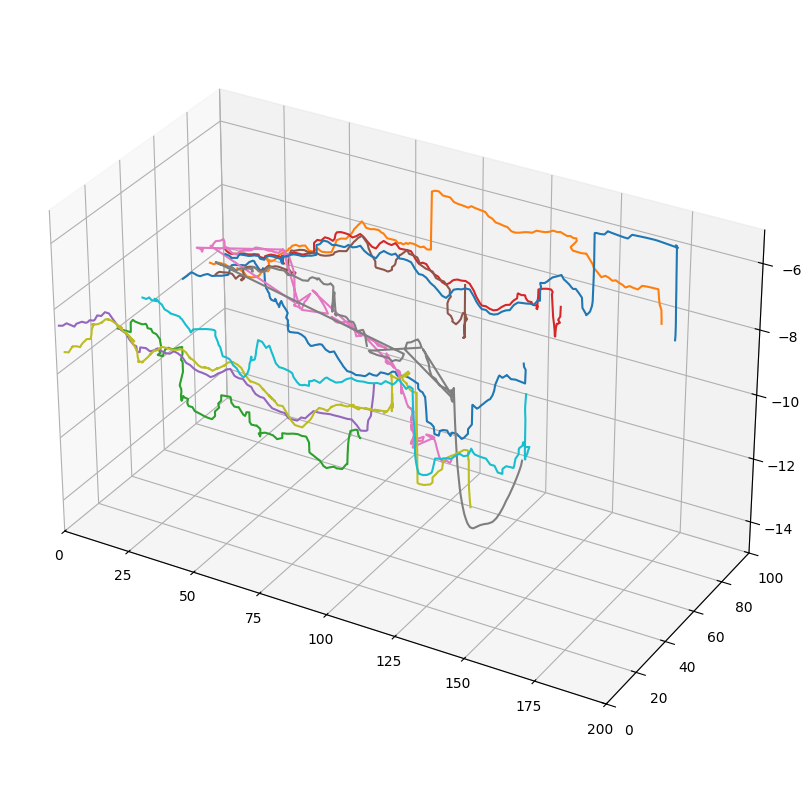

Exception raised
Exception raised
KeyError('964ad707559ffe1f0e53f177082b3801_134406f')
Traceback (most recent call last):
  File "c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\wslink\protocol.py", line 313, in onCompleteMessage
    results = func(*args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\trame_vtk\modules\vtk\protocols\local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "c:\Users\schorppl\AppData\Local\miniconda3\envs\bebou\Lib\site-packages\trame_vtk\modules\vtk\serializers\synchronization_context.py", line 35, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
                ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
KeyError: '964ad707559ffe1f0e53f177082b3801_134406f'

Exception raised
KeyError('964ad707559ffe1f0e53f177082b3801_134406f')
Traceback (most recent call last):
  File "c:\Users\schorppl\AppData\L

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

for df in l_df_pi:
    ax.plot(df["x"], df["y"], df["z"])
    
plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, -5)
ax.set_aspect("equalxy")
plt.show()

In [ ]:
df = pd.DataFrame(archpy_flow.mp_get_pathlines_object().get_data(6))
df.time /= 86400

Next cell allows to visually compare pathlines of a specific particle between the three modes.

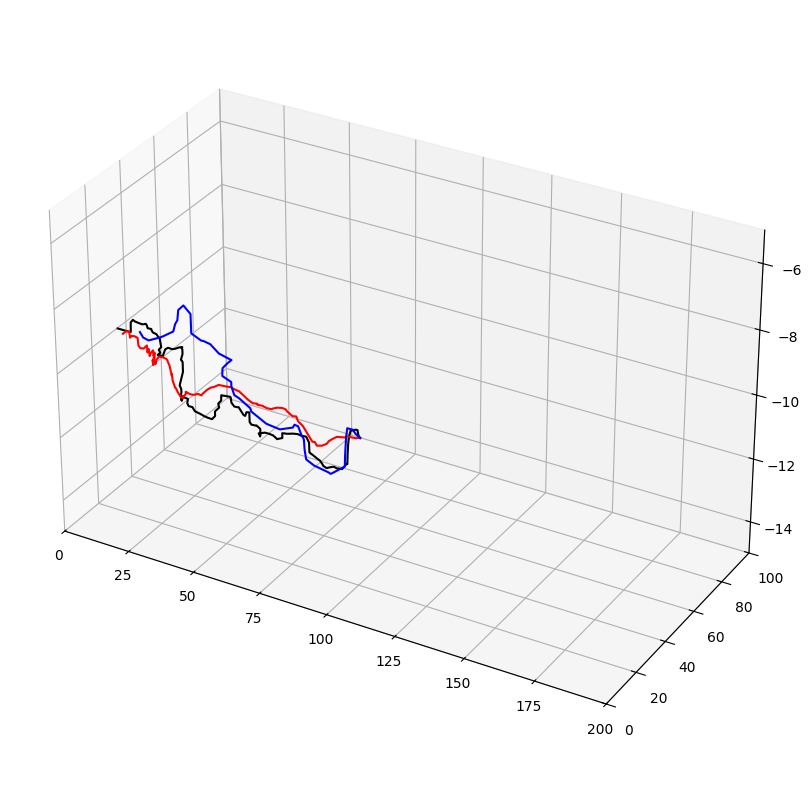

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

i_particle = 2
for df in [l_df_pi[i_particle]]:
    ax.plot(df["x"], df["y"], df["z"], color="k")

for df in [l_df_pi_layers[i_particle]]:
    ax.plot(df["x"], df["y"], df["z"], color="r")
    # ax.scatter(df["x"], df["y"], df["z"], color="r")
for df in [l_df_pi_new_res[i_particle]]:
    ax.plot(df["x"], df["y"], df["z"], color="b")
    
plt.xlim(0, 200)
plt.ylim(0, 100)
ax.set_zlim(-15, -5)
ax.set_aspect("equalxy")
plt.show()

However, this is not sufficient to exactly determine the impact of upscaling on pathlines, we need to quantify the differences between the curves.

The following cell shows a comparison between the three modes. The pathlines are compared using different distance (Frechet, Hausdorff, and DTW)

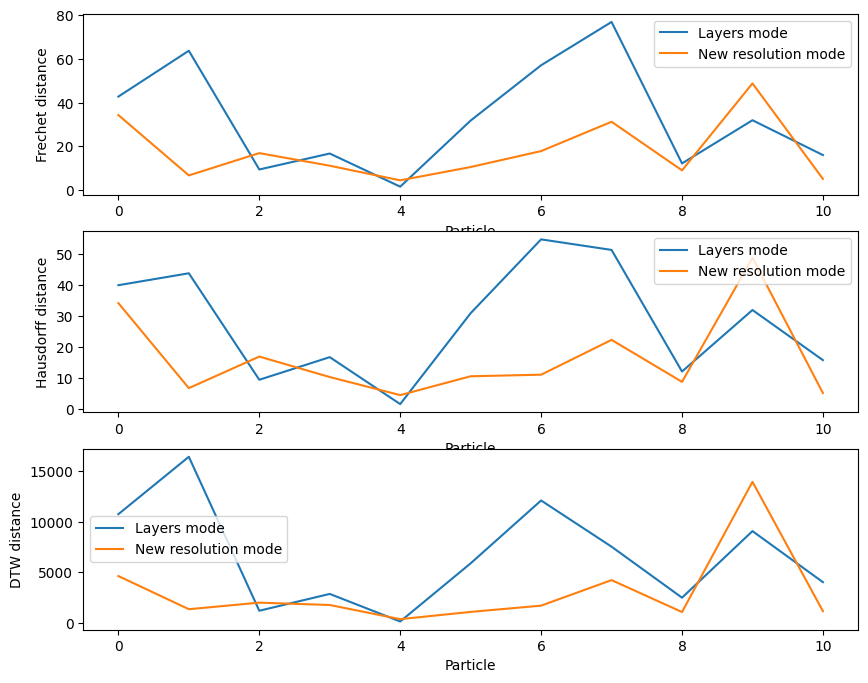

Frechet distance
Layers mode:  32.74372612548282
New resolution mode:  17.852089719160784
Hausdorff distance
Layers mode:  28.038506017615077
New resolution mode:  16.309409924021278
DTW distance
Layers mode:  6577.265880904196
New resolution mode:  3004.2489297134916


In [ ]:
# write a function to compute the frechet distance between two pathlines
import scipy
from scipy.spatial import distance

def DTW(path1, path2):
    """
    Compute the Dynamic Time Warping distance between two pathlines (path1 and path2)
    """

    # compute the distance between each point of the two pathlines
    dist = distance.cdist(path1, path2)

    # compute frechet matrix
    MF = np.zeros(dist.shape)
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            if i == 0 and j == 0:
                MF[i, j] = dist[i, j]
            elif i == 0:
                MF[i, j] = dist[i, j]
            elif j == 0:
                MF[i, j] = dist[i, j]
            else:
                MF[i, j] = dist[i, j] + min(MF[i-1, j], MF[i, j-1], MF[i-1, j-1])

    return MF[-1, -1]

def frechet_distance(path1, path2):

    """
    Compute the Frechet distance between two pathlines (2D array of shape (n_points, 3))

    """

    # compute the distance between each point of the two pathlines
    dist = distance.cdist(path1, path2)

    # compute frechet matrix
    MF = np.zeros(dist.shape)
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            if i == 0 and j == 0:
                MF[i, j] = dist[i, j]
            elif i == 0:
                MF[i, j] = max(MF[i, j-1], dist[i, j])
            elif j == 0:
                MF[i, j] = max(MF[i-1, j], dist[i, j])
            else:
                MF[i, j] = max(min(MF[i-1, j], MF[i, j-1], MF[i-1, j-1]), dist[i, j])
    
    return MF[-1, -1]

def hausdorff_distance(path1, path2):
    """
    Compute the Hausdorff distance between two pathlines
    """
    
    from scipy.spatial.distance import directed_hausdorff

    d1 = directed_hausdorff(path1, path2)
    return d1[0]


l_layer_frechet = []
l_new_res_frechet = []
l_layer_hausdorff = []
l_new_res_hausdorff = []
l_layer_dtw = []
l_new_res_dtw = []
for i_particle in range(n_loc):
    if i_particle in []:
        pass
    else:
        # compute frechet and hausdorffdistance
        path1 = l_df_pi[i_particle][["x", "y", "z"]].values
        path2 = l_df_pi_layers[i_particle][["x", "y", "z"]].values
        l_layer_frechet.append(frechet_distance(path1, path2))
        l_layer_hausdorff.append(hausdorff_distance(path1, path2))

        path2 = l_df_pi_new_res[i_particle][["x", "y", "z"]].values
        l_new_res_frechet.append(frechet_distance(path1, path2))
        l_new_res_hausdorff.append(hausdorff_distance(path1, path2))
        
        # # DTW
        path1 = l_df_pi[i_particle][["x", "y", "z", "time"]]

        path2 = l_df_pi_layers[i_particle][["x", "y", "z", "time"]]

        # # merge the two dataframes on time
        df_merge = pd.merge(path1, path2, on="time", suffixes=("_1", "_2"), how="outer").fillna(method="ffill").set_index("time")
        path1 = df_merge[["x_1", "y_1", "z_1"]]
        path2 = df_merge[["x_2", "y_2", "z_2"]]

        l_layer_dtw.append(DTW(path1.values, path2.values))

        path1 = l_df_pi[i_particle][["x", "y", "z", "time"]]

        path2 = l_df_pi_new_res[i_particle][["x", "y", "z", "time"]]

        # # merge the two dataframes on time
        df_merge = pd.merge(path1, path2, on="time", suffixes=("_1", "_2"), how="outer").fillna(method="ffill").set_index("time")
        path1 = df_merge[["x_1", "y_1", "z_1"]]
        path2 = df_merge[["x_2", "y_2", "z_2"]]
        l_new_res_dtw.append(DTW(path1.values, path2.values))


fig, ax = plt.subplots(3, 1, figsize=(10, 8))
ax[0].plot(l_layer_frechet, label="Layers mode")
ax[0].plot(l_new_res_frechet, label="New resolution mode")
ax[0].set_xlabel("Particle")
ax[0].set_ylabel("Frechet distance")
ax[0].legend()

ax[1].plot(l_layer_hausdorff, label="Layers mode")
ax[1].plot(l_new_res_hausdorff, label="New resolution mode")
ax[1].set_xlabel("Particle")
ax[1].set_ylabel("Hausdorff distance")
ax[1].legend()

ax[2].plot(l_layer_dtw, label="Layers mode")
ax[2].plot(l_new_res_dtw, label="New resolution mode")
ax[2].set_xlabel("Particle")
ax[2].set_ylabel("DTW distance")
ax[2].legend()

plt.show()

print("Frechet distance")
print("Layers mode: ", np.mean(l_layer_frechet))
print("New resolution mode: ", np.mean(l_new_res_frechet))
print("Hausdorff distance")
print("Layers mode: ", np.mean(l_layer_hausdorff))
print("New resolution mode: ", np.mean(l_new_res_hausdorff))
print("DTW distance")
print("Layers mode: ", np.mean(l_layer_dtw))
print("New resolution mode: ", np.mean(l_new_res_dtw))

We see that the new_resolution is the closest to the archpy mode, which is logical as it contains more cells than layer mode and better represent the heterogeneity of the model.

This concludes this notebook on the basics of archpy2modflow.